# Comparing Molecules among Molecular Libraries

In [1]:
import pickle
import pandas as pd
import numpy as np
from rdkit import Chem
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('..')
sns.set(style='white', context='talk', font_scale=0.9)

RDKit WARNING: [12:11:23] Enabling RDKit 2019.09.1 jupyter extensions


#### Load the data

In [2]:
# Import the dictionary of dataframes with the rdkit molecules
file_rd_mols = './fxa_rdkit_db_molecules.obj'
with open(file_rd_mols, 'rb') as f:
    lig_datasets = pickle.load(f)

In [3]:
print(lig_datasets.keys())
print('\n' + '-'* 50 + '\nExample:')
lig_datasets['COCRYS'].head(3)

dict_keys(['COCRYS', 'DUD', 'DEKOIS'])

--------------------------------------------------
Example:


,Activity,mol_rdk,sanitized
Lig,,,
RPR,active,<rdkit.Chem.rdchem.Mol object at 0x7f415c8dc870>,False
815,active,<rdkit.Chem.rdchem.Mol object at 0x7f415c8dc8b0>,True
PR2,active,<rdkit.Chem.rdchem.Mol object at 0x7f415c8dc8f0>,True


## Using RDKit to evaluate some molecular descriptors
##### The following function computes some features like Molecular Mass, number of heavy atoms, number of rotamers and number of rings.

In [4]:
from rdkit.Chem import Descriptors, Lipinski, rdMolDescriptors
from rdkit.Chem.rdmolops import FastFindRings

# Get the molecular weight and # of heavy atoms for each ligand
for dataset in lig_datasets.values():
    # molecular weight
    dataset['MW'] = [round(Descriptors.MolWt(m), 3) for m in dataset['mol_rdk']]
    # number of heavy atoms
    dataset['num_atoms'] = [round(Chem.Lipinski.HeavyAtomCount(m), 3) for m in dataset['mol_rdk']]
    # Update ring properties
    mol_update = [FastFindRings(m) for m in dataset['mol_rdk']]
    # Get number of rotamers
    dataset['num_rot'] = [round(Chem.Lipinski.NumRotatableBonds(m), 3) for m in dataset['mol_rdk']]
    # Get number of rings
    dataset['num_rings'] = [round(rdMolDescriptors.CalcNumRings(m), 3) for m in dataset['mol_rdk']]

### Plots

In [5]:
# Import some helper functions
from helper_functions_2 import violin_plot_helper, swarm_plot_helper

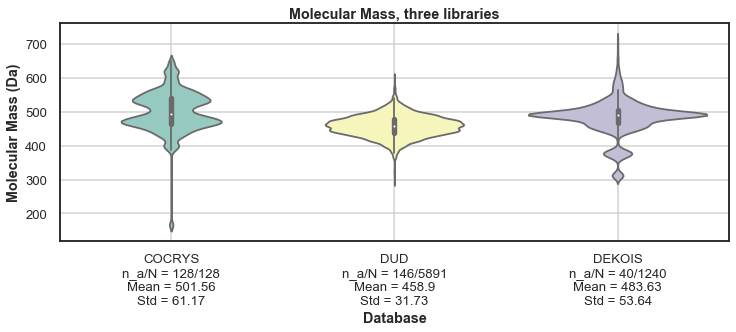

In [6]:
violin_plot_helper('MW', lig_datasets,
                   title = 'Molecular Mass, three libraries', palette= 'Set3',
                   xlabel= 'Database', ylabel = 'Molecular Mass (Da)', split_by_activity=False, )

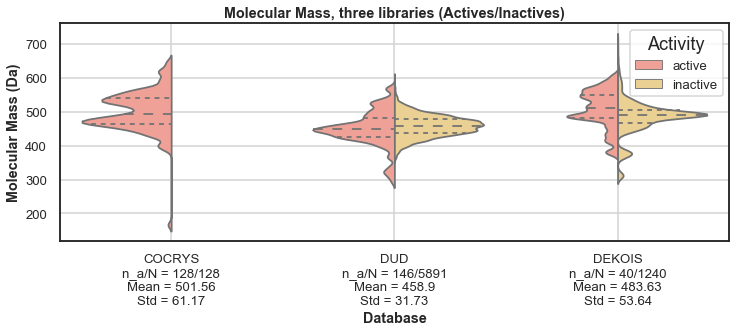

In [7]:
violin_plot_helper('MW', lig_datasets,
                   title = 'Molecular Mass, three libraries (Actives/Inactives)',
                   palette=['#FF9588', '#FAD585'], inner="quartile",
                   xlabel= 'Database', ylabel = 'Molecular Mass (Da)', split_by_activity=True)

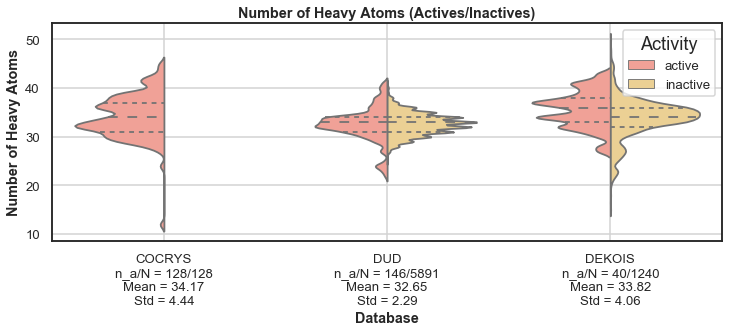

In [8]:
violin_plot_helper('num_atoms', lig_datasets,
                   title = 'Number of Heavy Atoms (Actives/Inactives)',
                   palette=['#FF9588', '#FAD585'], inner="quartile",
                   xlabel= 'Database', ylabel = 'Number of Heavy Atoms', split_by_activity=True)

## Merge the data frames

In [9]:
# Get a dataframe for each library 
library_names = ['COCRYS', 'DEKOIS', 'DUD']
dfs_list = []

# add a new column
for name in library_names:
    df = lig_datasets[name]
    # Add new column with its name
    df['library'] = name
    # Append to the df list
    dfs_list.append(df)

# Concat
df_all_mols = pd.concat(dfs_list, ignore_index=False).reset_index()
df_all_mols = df_all_mols.rename(columns={'index': 'name'})

## Compute Fingerprints

### Extract fingerprint dataframes

In [10]:
%%time
# compute MACCS Fingerprints
from rdkit.Chem import MACCSkeys
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
from rdkit.Chem import DataStructs

def fps_to_array(fps, drop_constant_cols=True):
    """Convert a list of molecular fingerprints into a 
    numpy m*n array, where n = # molecules and n = # fps"""
    def fp2arr(fp):
        arr = np.zeros((0,))
        DataStructs.ConvertToNumpyArray(fp, arr)
        return arr
    X = np.asarray([fp2arr(fp) for fp in fps])
    if drop_constant_cols:
        X = pd.DataFrame(X)
        X = X.loc[:, X.var() != 0.0] 
    return X 


# Maccs Fingerprints
fps_all_maccs = [MACCSkeys.GenMACCSKeys(i) for i in df_all_mols.mol_rdk]
X_all_maccs = fps_to_array(fps_all_maccs)
print("MACCS Fps:", X_all_maccs.shape)
    
# Morgan Fingerprints
fps_all_morgan = [GetMorganFingerprintAsBitVect(i, radius=2) for i in df_all_mols.mol_rdk]
X_all_morgan = fps_to_array(fps_all_morgan)
print("Morgan Fps:", X_all_morgan.shape)

# RDKit Fingerprints
fps_all_rdk = [Chem.RDKFingerprint(i) for i in df_all_mols.mol_rdk]
X_all_rdk = fps_to_array(fps_all_rdk)
print("RDKit Fps:", X_all_rdk.shape)


MACCS Fps: (7259, 150)
Morgan Fps: (7259, 2048)
RDKit Fps: (7259, 2048)
CPU times: user 25.5 s, sys: 668 ms, total: 26.2 s
Wall time: 26.2 s


### Compare Molecules among datasets using MACCS Fingerprints

In [11]:
from helper_functions_2 import draw_matched_ligs, compare_lig_db

### Redundant Molecules

In [12]:
%%time
import os

'''The following list should have the same order of molecules, i.e., 
the same index should refers to the same molecule info in all list'''

# The following file will save the results
file_matched_mols = './df_repeated_mols_among_DUD_DEKIOS_COCRYS.pkl'

if not os.path.isfile(file_matched_mols):
    # Create a list of tuples to save the pair of matched molecules
    indices = df_all_mols.index.values
    names = df_all_mols.name.values
    mols = df_all_mols.mol_rdk.values
    libraries = df_all_mols.library.values
    fps = fps_all_morgan # We'll use Morgan fingerprints

    matched_molecules = []
    for j, k in combinations(indices, 2):
        fp_sim = FingerprintSimilarity(fps[j], fps[k],
                       metric=DataStructs.TanimotoSimilarity)
        if fp_sim == 1: # If similarity is equal to one
           matched_molecules.append( (names[j], names[k], libraries[j] + '_' + libraries[k]) )
    # Create a dataframe
    df_matched_mols = pd.DataFrame(matched_molecules, columns = ['mol1', 'mol2', 'libraries'])
    df_matched_mols.to_pickle(file_matched_mols)
    
else:
    df_matched_mols = pd.read_pickle(file_matched_mols)
    
# ***********************************
# Sort by library and by mol1 column
# ***********************************
df_matched_mols.sort_values(['libraries', 'mol1'], inplace=True)

print('Number of repeated molecules among different or the same database:\n', df_matched_mols.shape[0])

Number of repeated molecules among different or the same database:
 2033
CPU times: user 7.23 ms, sys: 162 µs, total: 7.4 ms
Wall time: 6.46 ms


#### How many molecules are repeated among a pair  of molecular libraries

In [13]:
df_matched_mols['libraries'].value_counts().sort_index()

COCRYS_COCRYS       3
COCRYS_DEKOIS       1
COCRYS_DUD          5
DEKOIS_DEKOIS      21
DEKOIS_DUD          2
DUD_DUD          2001
Name: libraries, dtype: int64

#### How many molecules are decoys?

In [14]:
# How many of the repeated molecules are decoys?
df_matched_mols.mol1.str.contains('^decoy').sum()

2019

### Update Data frames removing repeated molecules

First, identify which molecules should be removed.

In [15]:
set_to_drop = set()

col_mol1_unique = df_matched_mols.mol1.unique()
for mol1 in col_mol1_unique:
    rows = df_matched_mols[['mol2', 'libraries']][df_matched_mols.mol1 == mol1]
    # Select the library; the '$' character indicates the separation between name and library
    elements_to_drop = rows.apply(lambda x: x.values[0] + '$' + x.values[1].split('_')[1], axis=1).to_list()
    
    # Move the name to the set
    set_to_drop.update(elements_to_drop)
    
print('Number of molecules to drop', len(set_to_drop))

Number of molecules to drop 1420


#### Helper function

In [16]:
# ******************************************
# Helper funtion to drop repeated molecules
# ******************************************
def drop_repeated_mols(df, mols_to_drop, temp_index):
    '''Drops rows from a given dataframe.'''
    temp_df = df.copy()
    temp_df['temp_index'] = temp_index
    temp_df = temp_df.set_index('temp_index')
    # drop molecules
    temp_df = temp_df.drop(mols_to_drop, axis=0)
    # reset index and drop temporal column
    temp_df = temp_df.reset_index().drop('temp_index', axis=1)
    return temp_df

### Update the original data frames

In [17]:
# From the original MERGED dataset, create a temporal column with mol_name$library and set it as index
temp_index = df_all_mols[['name', 'library']].apply(lambda x: x.values[0] + '$' + x.values[1], axis=1).to_list()

#*********************************
# Update the original data frames
#*********************************

# Main DataFrame
df_all_mols = drop_repeated_mols(df_all_mols, set_to_drop, temp_index)
# MACCS Fps
X_all_maccs = drop_repeated_mols(X_all_maccs, set_to_drop, temp_index)
# Morgan Fps
X_all_morgan = drop_repeated_mols(X_all_morgan, set_to_drop, temp_index)
# RDKit Fps
X_all_rdk = drop_repeated_mols(X_all_rdk, set_to_drop, temp_index)



## Dimensionality Reduction
### t-SNE
**If the number of features (descriptors) is too big, PCA could be performed before t-SNE to reduce the size of the dataset.**

In [18]:
from sklearn.manifold import TSNE

In [19]:
# Create a dataframe with t-sne dimensions and other features
df_dim_project = df_all_mols.copy()[['library', 'name', 'mol_rdk', 'Activity', 'num_rings', 'num_atoms', 'num_rot']]

In [20]:
%%time
import os 
pkl_file = './df_COCRYS_DUD_DEKOIS_with_Fingerprints_1.pkl'

#**************
# Compute t-SNE
#**************
# Function to copute tSNE
def do_tsne(desc_set, X_set, out_df, learning_rate=50, **kwargs):
    tsne = TSNE(learning_rate=learning_rate, **kwargs)
    tsne_dims = tsne.fit_transform(X_set)
    # append the tsne_dims
    out_df[desc_set + '_tsne_x'] = tsne_dims[:, 0]
    out_df[desc_set + '_tsne_y'] = tsne_dims[:, 1]
    

if os.path.isfile(pkl_file): 
    df_dim_project = pd.read_pickle(pkl_file)
else:
    # Compute the t-sne
    # MACCS Fps
    do_tsne('maccs', X_all_maccs, df_dim_project)
    # Morgan Fps
    do_tsne('morgan', X_all_morgan, df_dim_project)
    # RDKit Fps
    do_tsne('rdk', X_all_rdk, df_dim_project)
    
    # Save the dataframe with the transformed dimensions
    df_dim_project.to_pickle(pkl_file)

CPU times: user 11min 53s, sys: 4min 30s, total: 16min 24s
Wall time: 5min 55s


## Plot with bokeh

In [21]:
from bokeh.io import output_notebook
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, CDSView, GroupFilter, \
                            Span, CategoricalColorMapper, HoverTool
from bokeh.layouts import row, column
from bokeh.transform import factor_cmap, factor_mark
output_notebook()

Loading BokehJS ...

In [22]:
# Create the columndatasource
source_act = ColumnDataSource(data= df_dim_project[df_dim_project.Activity == 'active'].drop('mol_rdk', axis=1))
source_inact = ColumnDataSource(data= df_dim_project[df_dim_project.Activity == 'inactive'].drop('mol_rdk', axis=1))

# *******************************
# General parameters and values 
# *******************************
# Create the color and marker mappers
LIBRARIES = np.unique(source_act.data['library'])
ACTIVITY = np.unique(source_act.data['Activity'])
# Color mappers
col_library_map = factor_cmap('library', ['#20C55A', '#FF5733', '#857CEA'], LIBRARIES)

# Vertical line
vline = Span(location=0, dimension='height', 
             line_color='black', line_width=2, line_alpha=0.5, line_dash='dashed')
# Horizontal line
hline = Span(location=0, dimension='width', 
             line_color='black', line_width=2, line_alpha=0.5, line_dash='dashed')
# HoverTool options
hover= HoverTool(tooltips=[ ('Name', '@name'), ('# Atoms', '@num_atoms'),('Library', '@library'),
          ('Activity', '@Activity')], names = ['actives'])
                            
def create_fig(desc, title='', kind_dr='tsne', legend_location='top_right'):
    ''' ColumnDataSources source_act  and source_inact must be instantiated'''
    f = figure(title=title, plot_width=550, plot_height=550,
          x_axis_label='First Dimension', y_axis_label='Second Dimension',
          tools='box_select,wheel_zoom,reset')
    # Add hovertool 
    
    f.renderers.extend([vline, hline])
    # Add glyphs
    # Plot inactives
    f_inac = f.circle(x= desc + f'_{kind_dr}_x', y= desc + f'_{kind_dr}_y', 
               color=col_library_map,
               nonselection_fill_color=col_library_map,
               nonselection_fill_alpha=0.05,
               size=4, alpha=0.15, line_width=0,
               muted_alpha=0.01,
               source=source_inact)

    # Plot actives
    f_act = f.triangle(x= desc + f'_{kind_dr}_x', y= desc + f'_{kind_dr}_y',
               color=col_library_map, legend_group='library',
               nonselection_fill_color=col_library_map,
               nonselection_fill_alpha=0.05,
               size=8, line_color='black', line_width=0.5, 
               source=source_act, name='actives')
    hover.renderers = [f_act]
    f.add_tools(hover)
    
    # Styling
    f.title.text_font_size = '1.4em'
    f.axis.axis_label_text_font_size = '1.0em' # font size
    f.axis.axis_label_text_font_style = 'bold'
    f.title.align = 'center'
    f.axis.axis_line_width = 3
    f.axis.major_label_text_font_size = '12pt'
    f.legend.click_policy='mute'
    f.legend.location = legend_location
    return f
    
# ******************
# Create the figures
# ******************
maccs_plot = create_fig('maccs', title='t-SNE: MACCS Keys')
morgan_plot = create_fig('morgan', title='t-SNE: Morgan Fps')
rdk_plot = create_fig('rdk', title='t-SNE: RDKit Fps')

layout = column(row(maccs_plot, morgan_plot), rdk_plot)

show(layout)

### Tanimoto Heatmap

In [23]:
# Select only active molecules
actives_filter = df_all_mols.Activity == 'active'
df_actives = df_all_mols[actives_filter]

In [24]:
%%time
from scipy.spatial.distance import pdist, squareform

# function to compute the similarity and distance matrix
def get_distance_mtx(df, dist='jaccard'):
    dist_mtx = squareform( pdist(df, dist))
    return dist_mtx

def get_similarity_mtx(df, dist='jaccard'):
    dist_mtx = get_distance_mtx(df, dist)
    sim_mtx = 1 - dist_mtx
    return sim_mtx

#**************************
# Compute similarity matric
#**************************

# MACCS
df = X_all_maccs[actives_filter]
siml_mtx_maccs = get_similarity_mtx(df, dist='jaccard') 

# Morgan 
df = X_all_morgan[actives_filter]
siml_mtx_morgan = get_similarity_mtx(df, dist='jaccard')  

# RDKit 
df = X_all_rdk[actives_filter]
siml_mtx_rdk = get_similarity_mtx(df, dist='jaccard')  

CPU times: user 628 ms, sys: 337 µs, total: 629 ms
Wall time: 626 ms


### Clustermaps

In [25]:
from matplotlib import gridspec

# Activity side bars Colors
library_colors = ['#20C55A' if i == 'COCRYS'
                  else '#FF5733' if i == 'DEKOIS'
                  else '#857CEA' for i in df_actives.library]

# Function to plot the clustermap given a similarity matrix
def plot_cluster_map(mtx, title, col_cluster=False, row_cluster=False, figsize=(6,6),
                     col_colors=library_colors, row_colors=library_colors,
                     cbar_pos=(1, 0.3, 0.03, 0.5), dendrogram_ratio= (0.01, 0.01),
                     **kwargs):
    clusmap = sns.clustermap(mtx, cmap='YlGnBu',
                        col_cluster=col_cluster, row_cluster=row_cluster,
                        col_colors=library_colors, row_colors=library_colors,
                        cbar_pos=cbar_pos, dendrogram_ratio=dendrogram_ratio,
                        figsize=figsize, **kwargs)
    clusmap.fig.suptitle(title, y=1.01, fontweight='bold')
    return clusmap


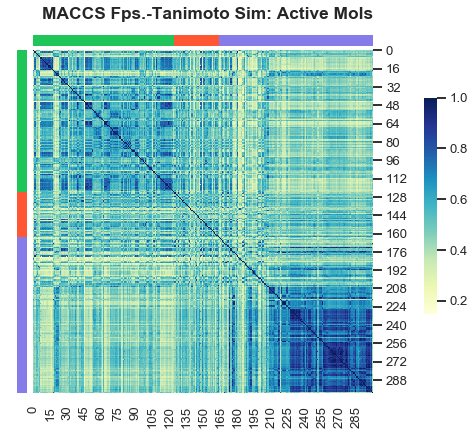

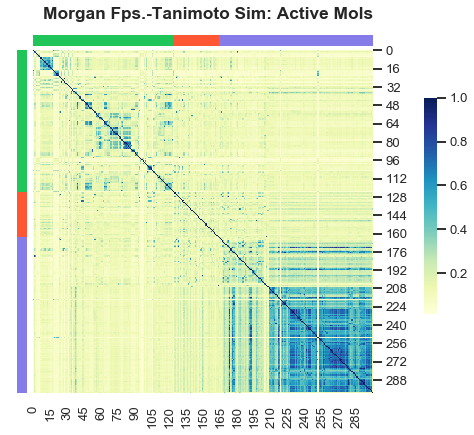

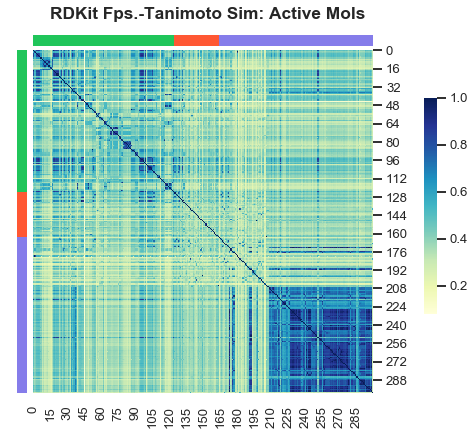

In [33]:
#*********************
# Plot the clustermaps: Without Clustering
#*********************
clusmap_maccs = plot_cluster_map(siml_mtx_maccs, title='MACCS Fps.-Tanimoto Sim: Active Mols')
clusmap_morgan = plot_cluster_map(siml_mtx_morgan, title='Morgan Fps.-Tanimoto Sim: Active Mols')
clusmap_rdk = plot_cluster_map(siml_mtx_rdk, title='RDKit Fps.-Tanimoto Sim: Active Mols')
plt.show()

/home/joel/anaconda3/envs/mds/lib/python3.7/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


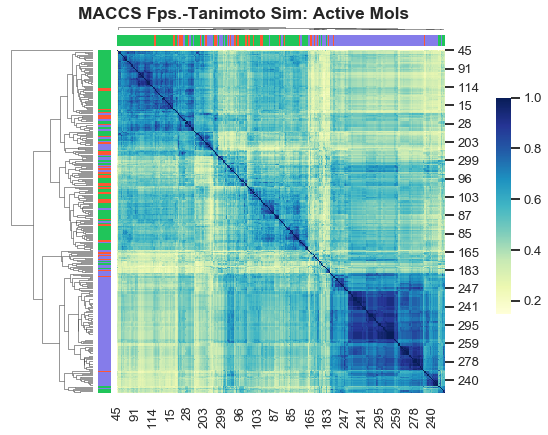

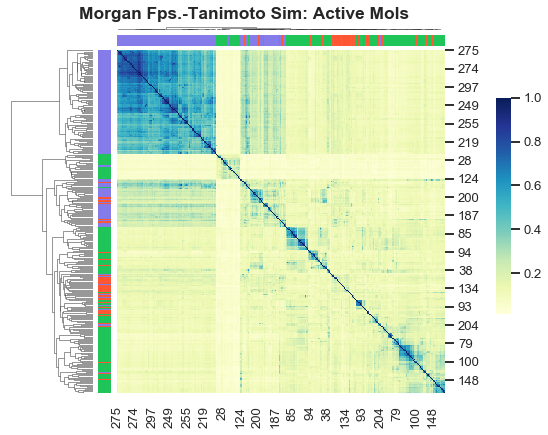

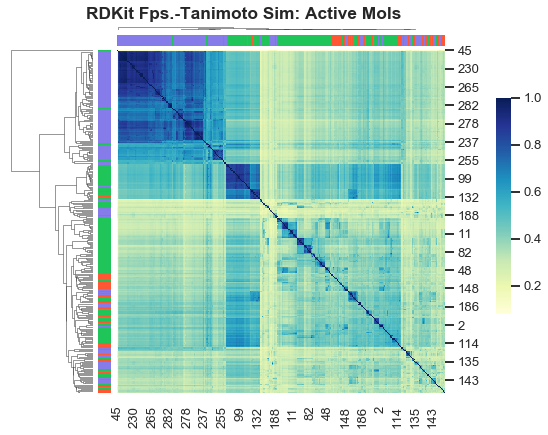

In [27]:
#*********************
# Plot the clustermaps
#*********************
clusmap_maccs = plot_cluster_map(siml_mtx_maccs, title='MACCS Fps.-Tanimoto Sim: Active Mols',
                    col_cluster=True, row_cluster=True, dendrogram_ratio=(0.2, 0.01), figsize=(7,6))
clusmap_morgan = plot_cluster_map(siml_mtx_morgan, title='Morgan Fps.-Tanimoto Sim: Active Mols',
                    col_cluster=True, row_cluster=True, dendrogram_ratio=(0.2, 0.01), figsize=(7,6))
clusmap_rdk = plot_cluster_map(siml_mtx_rdk, title='RDKit Fps.-Tanimoto Sim: Active Mols',
                    col_cluster=True, row_cluster=True, dendrogram_ratio=(0.2, 0.01), figsize=(7,6))
plt.show()

## MDS
#### First compute the distance matrix of active molecules

In [38]:
# Create two filters for active an inactive molecules
active_idx = df_all_mols[df_all_mols.Activity == 'active'].index
inactive_idx = df_all_mols[df_all_mols.Activity == 'inactive'].index

In [39]:
%%time
# **********
# Compute distance matrix
# **********
# Because it takes a several minutes we saved it in the following file to avoid compute it again
pkl_file = './df_COCRYS_DUD_DEKOIS_with_Fingerprints_2.pkl'
if os.path.isfile(pkl_file): 
    pass 
else:
    # MACCS
    df = X_all_maccs
    dist_mtx_maccs = get_distance_mtx(df, dist='jaccard') 
    act_dist_maccs = dist_mtx_maccs[active_idx, :][:, active_idx]
    sup_dist_maccs = dist_mtx_maccs[inactive_idx, :][:, active_idx]

    # Morgan 
    df = X_all_morgan
    dist_mtx_morgan = get_distance_mtx(df, dist='jaccard')  
    act_dist_morgan = dist_mtx_morgan[active_idx, :][:, active_idx]
    sup_dist_morgan = dist_mtx_morgan[inactive_idx, :][:, active_idx]

    # RDKit 
    df = X_all_rdk
    dist_mtx_rdk = get_distance_mtx(df, dist='jaccard')  
    act_dist_rdk = dist_mtx_rdk[active_idx, :][:, active_idx]
    sup_dist_rdk = dist_mtx_rdk[inactive_idx, :][:, active_idx]

CPU times: user 3min 22s, sys: 2.99 s, total: 3min 25s
Wall time: 3min 25s


#### Import MDS class

In [40]:
import sys
sys.path.append('..')

from modules.MDS import cMDS, cMDS_proj

In [41]:
# function to add MDS projections to the main dataframe
def add_xy_mds_colums(df, desc_set, actives_mds, inactives_mds, active_idx, inactive_idx):
    df[desc_set + '_mds_x'] = 0
    df[desc_set + '_mds_x'].iloc[active_idx] = actives_mds[0]
    df[desc_set + '_mds_x'].iloc[inactive_idx] = inactives_mds.T[0]
    df[desc_set + '_mds_y'] = 0
    df[desc_set + '_mds_y'].iloc[active_idx] = actives_mds[1]
    df[desc_set + '_mds_y'].iloc[inactive_idx] = inactives_mds.T[1]
    return df

In [42]:
# Compute MDS over active molecules and project inactive ones
pkl_file = './df_COCRYS_DUD_DEKOIS_with_Fingerprints_2.pkl'

if  os.path.isfile(pkl_file): 
    df_dim_mds = pd.read_pickle(pkl_file)
else:
    # MACCS
    mds_maccs_obj = cMDS(act_dist_maccs)
    proj_maccs_actives = mds_maccs_obj[0]
    proj_maccs_inactives = cMDS_proj(mds_maccs_obj, sup_dist_maccs)

    # Morgan 
    mds_morgan_obj = cMDS(act_dist_morgan)
    proj_morgan_actives = mds_morgan_obj[0]
    proj_morgan_inactives = cMDS_proj(mds_morgan_obj, sup_dist_morgan)

    # RDKit 
    mds_rdk_obj = cMDS(act_dist_rdk)
    proj_rdk_actives = mds_rdk_obj[0]
    proj_rdk_inactives = cMDS_proj(mds_rdk_obj, sup_dist_rdk)

    # Add to the dataframe
    df_dim_mds = df_dim_project.copy() # Create a copy
    # MACCS
    add_xy_mds_colums(df_dim_mds, 'maccs', proj_maccs_actives, proj_maccs_inactives, active_idx, inactive_idx)
    # Morgan 
    add_xy_mds_colums(df_dim_mds, 'morgan', proj_morgan_actives, proj_morgan_inactives, active_idx, inactive_idx)
    # RDkit
    add_xy_mds_colums(df_dim_mds, 'rdk', proj_rdk_actives, proj_rdk_inactives, active_idx, inactive_idx)

    # Save the dataframe:
    df_dim_mds.to_pickle(pkl_file)

/home/joel/anaconda3/envs/mds/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


## cMDS Plots
#### cMDS space using only active molecules. Inactive molecules are projeted onto the active's space.

In [43]:
#**********
# Plotting
#**********
# Create the columndatasource
source_act = ColumnDataSource(data= df_dim_mds[df_dim_mds.Activity == 'active'].drop('mol_rdk', axis=1))
source_inact = ColumnDataSource(data= df_dim_mds[df_dim_mds.Activity == 'inactive'].drop('mol_rdk', axis=1))

# *********
# Create the figures
maccs_plot = create_fig('maccs', title='cMDS: MACCS Keys', kind_dr='mds')
morgan_plot = create_fig('morgan', title='cMDS: Morgan Fps.', kind_dr='mds', legend_location='top_left')
rdk_plot = create_fig('rdk', title='cMDS: RDKit Fps.', kind_dr='mds', legend_location='top_left')

# Create the layout
layout = column(row(maccs_plot, morgan_plot), rdk_plot)

# show(layout)

## Molecular Grid Maps
Sources:
> *Integrating the Structure-Activity Relationship Matrix Method with Molecular Grid Maps and Activity Landscape Models for Medicinal Chemistry Applications*: https://pubs.acs.org/doi/pdf/10.1021/acsomega.9b00595

> [*Visualize chemical space as a grid*](https://iwatobipen.wordpress.com/2019/08/27/visualize-chemical-space-as-a-grid-chemoinformatics-rdkit/)

> [*A shortest augmenting path algorithm for dense and sparse linear assignment problems*](https://link.springer.com/article/10.1007/BF02278710)

We'll use the following package from: https://github.com/src-d/lapjv, it let us to  perform the Jonker-Volgenat algorithm, commonly used to fit t-SNE results into a rectangular grid.


```python
!pip install lapjv
```

### Function to compute the Grid Map Embedding

In [44]:
from lapjv import lapjv
from scipy.spatial.distance import cdist

def grid_embedding_from_tsne(main_df, desc_set):
    ''' Performs a grid projection from t-SNE axes using the JV-algorithm.
    
    Parameters:
    -----------
    main_df: (pandas DataFrame)
        DataFrame with DESC_tsne_x and DESC_tsne_y columns previously computed.
        It must have "name", "Activity" and "Library" columns
    desc_set: (str)
        A string with the name of the descriptor set matching 
        the name of the x and y columns inside in main_df.
    '''
    
    # Extract in max normalization
    axes = [desc_set + '_tsne_x', desc_set + '_tsne_y']
    embeddings = main_df[axes] # Extract x and y axis
    embeddings -= embeddings.min(axis=0) # Subtract min
    embeddings /= embeddings.max(axis=0) # Divide between max - min
    # Add name, activity, and library columns
    embeddings = pd.concat([embeddings, main_df[['name', 'Activity', 'library']]], axis=1)
    
    # Grid projection
    #****************
    # Create the grid
    n_mols = embeddings.shape[0]
    grid_side_size = int(np.sqrt(n_mols))
    
    # Sample M number of molecules if the N is not a perfect square
    if np.sqrt(n_mols) % 2 != 0:
        embeddings = embeddings.sample(grid_side_size**2).sort_index()
    
    grid_space = np.linspace(0, 1, grid_side_size)
    grid = np.dstack(np.meshgrid(grid_space, grid_space)).reshape(-1, 2)
    
    # Compute euclidean distance between points given the normalized x and y axis
    cost_mat = cdist(grid, embeddings[axes], 'sqeuclidean')
    
    # Compute the JV-algorithm
    row_asses, col_asses, _ = lapjv(cost_mat)
    grid_lap = grid[col_asses]
    
    # Return a new dataframe with the new embedding coordinates
    embeddings[desc_set + '_tsne_grid_x'] = grid_lap[: , 0]
    embeddings[desc_set + '_tsne_grid_y'] = grid_lap[: , 1]
                            
    return embeddings 

#### Compute the Grid Maps from t-SNE results

In [45]:
%%time
# Funtions to run and save / load grid projections
# to avoid recomputing each time
def create_and_save_grid_tsne(main_df, desc_set):
    df_emb_grid = grid_embedding_from_tsne(main_df, desc_set)
    file = f'./grid_tsne_plot_{desc_set}_all_mols.csv'
    df_emb_grid.to_csv(file)
    return df_emb_grid

def load_grid_tsne(desc_set):
    file = f'./grid_tsne_plot_{desc_set}_all_mols.csv'
    return pd.read_csv(file)

#*************************
# Perform Grid Projection
#*************************
run_LV = True # Change if we want to recompute the grid embedding
if run_LV:
    grd_rdk = create_and_save_grid_tsne(df_dim_project, 'rdk')
    grd_morgan = create_and_save_grid_tsne(df_dim_project, 'morgan')
    grd_maccs = create_and_save_grid_tsne(df_dim_project, 'maccs')
else:
    grd_rdk = load_grid_tsne('rdk')
    grd_morgan = load_grid_tsne('morgan')
    grd_maccs = load_grid_tsne('maccs')

CPU times: user 3min 43s, sys: 395 ms, total: 3min 43s
Wall time: 3min 44s


In [46]:
# Auxiliar funtion to plot the embeddings coloring points by color and by library
def plot_grid_embedding(df_emb_grid, desc_set, title, color_set_1, color_set_2,
                       figsize=(16,5)):
    '''Return three plots containing tsne projection and grid embedding by color
    and library. The "main_df" should contain "Activity" and "library" columns along
    with the x and y columns with the t-SNE results'''
    
    # Plot the projections
    fig, ax = plt.subplots(1, 3, figsize=figsize)
    
    ax[0].scatter(df_emb_grid[desc_set + '_tsne_x'], df_emb_grid[desc_set + '_tsne_y'], c=color_set_1, s=5)
    ax[0].set(title='t-SNE projection', xlabel='Dim. 1 (normalized)', ylabel='Dim. 2 (normalized)')
    
    ax[1].scatter(df_emb_grid[desc_set + '_tsne_grid_x'], 
                  df_emb_grid[desc_set + '_tsne_grid_y'],  alpha=0.8, c=color_set_1, s=5)
    ax[1].get_xaxis().set_ticks([]); ax[1].get_yaxis().set_ticks([])
    ax[1].set(title='Grid Map Embedding: Color by library')
    
    ax[2].scatter(df_emb_grid[desc_set + '_tsne_grid_x'], 
                  df_emb_grid[desc_set + '_tsne_grid_y'], alpha=0.8, c=color_set_2, s=5)
    ax[2].get_xaxis().set_ticks([]); ax[2].get_yaxis().set_ticks([])
    ax[2].set(title='Grid Map Embedding: Color by Activity')
    fig.suptitle(title, fontweight='bold', y=1)
    plt.show()

In [47]:
#********************
# Define some colors
#********************
library_colors = ['#12B746' if i == 'COCRYS' else '#FB7E28' if i == 'DEKOIS'
                  else '#CBC2F0' for i in grd_maccs.library]
activity_color = ['#FA5656' if i == 'active' else '#FDE1A6' for i in grd_maccs.Activity]

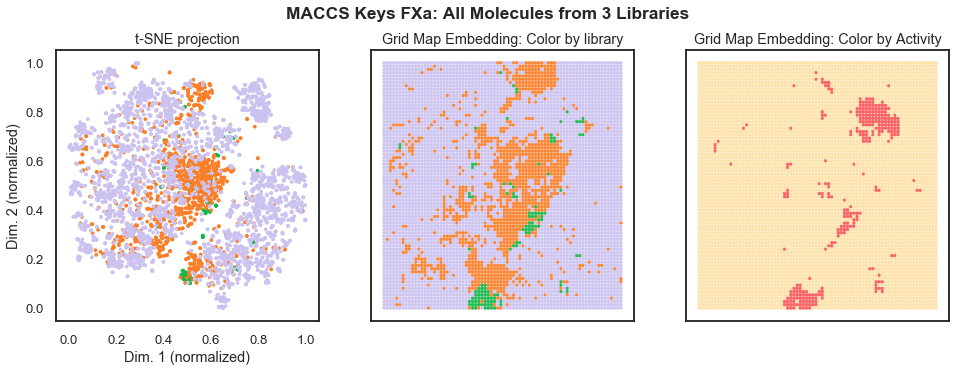

In [48]:
# Plot MACCS Keys
plot_grid_embedding(df_emb_grid=grd_maccs, desc_set='maccs',
                    title='MACCS Keys FXa: All Molecules from 3 Libraries',
                    color_set_1=library_colors, color_set_2=activity_color)

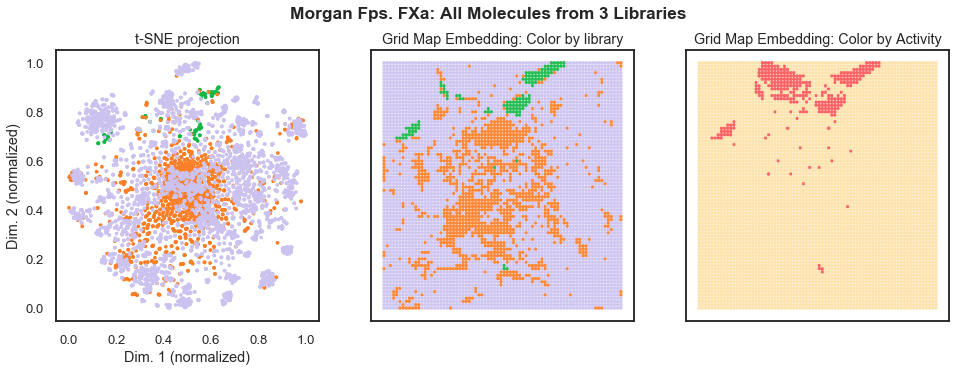

In [49]:
# Plot MACCS Keys
plot_grid_embedding(df_emb_grid=grd_morgan, desc_set='morgan',
                    title='Morgan Fps. FXa: All Molecules from 3 Libraries',
                    color_set_1=library_colors, color_set_2=activity_color)

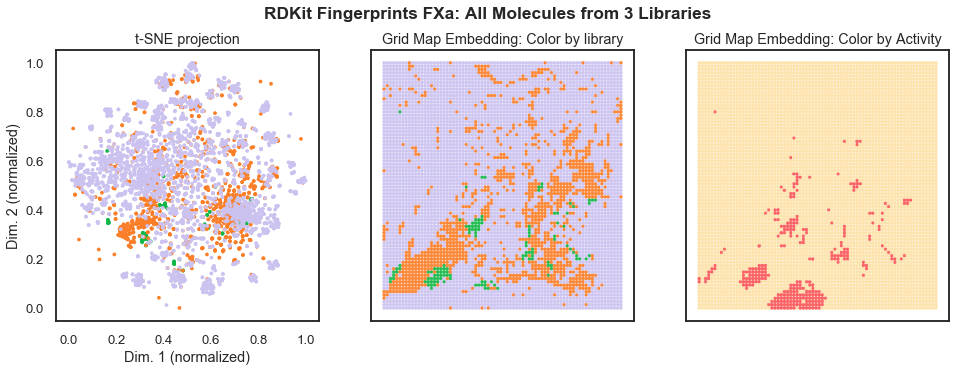

In [50]:
# Plot RDKit Fingerprints
plot_grid_embedding(df_emb_grid=grd_rdk, desc_set='rdk',
                    title='RDKit Fingerprints FXa: All Molecules from 3 Libraries',
                    color_set_1=library_colors, color_set_2=activity_color)

## Murcko Scaffolds

In [51]:
from rdkit.Chem.Scaffolds import MurckoScaffold 
from rdkit.Chem import MolToSmiles
from rdkit.Chem import rdDepictor

In [52]:
# Define a lambda function to compute Murcko scaffolds
def scaffold2smiles(mol, generic, return_smiles = True):
    ''' Returns a SMILES string representing the Murcko Scaffold of a given molecule'''
    if generic:
        # Makes a Murcko scaffold generic (all atoms -> carbon and all bonds -> single)
        scff = MurckoScaffold.MakeScaffoldGeneric(mol)
        scff = MurckoScaffold.GetScaffoldForMol(scff)
        scff_smiles = MolToSmiles(scff)
    else:
        # Return a smiles scaffold 
        try:
            scff = MurckoScaffold.GetScaffoldForMol(mol)
            scff_smiles =  MolToSmiles(scff)
        except:
            scff_smiles = np.nan
            scff = np.nan
    if return_smiles:
        return scff_smiles
    else:
        return scff

In [53]:
# ************
# Function to compute 2d coords
# ************
to2d = Chem.rdDepictor.Compute2DCoords

In [54]:
%%time
# Compute Generic Murko Scaffolds
generic_murcko_smiles = [scaffold2smiles(mol, generic=True, return_smiles=True) 
                         for mol in df_all_mols.mol_rdk]

# Compute Murcko Scaffolds as SMILES
murcko_smiles = [scaffold2smiles(mol, generic=False, return_smiles=True) 
                 for mol in df_all_mols.mol_rdk]

RDKit ERROR: [12:31:36] Explicit valence for atom # 12 N, 4, is greater than permitted
RDKit ERROR: [12:31:36] Explicit valence for atom # 10 C, 6, is greater than permitted
RDKit ERROR: [12:31:36] Explicit valence for atom # 32 N, 4, is greater than permitted
RDKit ERROR: [12:31:36] Explicit valence for atom # 17 C, 6, is greater than permitted
RDKit ERROR: [12:31:36] Explicit valence for atom # 7 N, 4, is greater than permitted
RDKit ERROR: [12:31:36] Explicit valence for atom # 4 C, 6, is greater than permitted
RDKit ERROR: [12:31:37] Explicit valence for atom # 21 N, 4, is greater than permitted
RDKit ERROR: [12:31:38] Explicit valence for atom # 20 N, 4, is greater than permitted
RDKit ERROR: [12:31:38] Explicit valence for atom # 13 N, 4, is greater than permitted


CPU times: user 10.1 s, sys: 173 ms, total: 10.3 s
Wall time: 10.3 s


### Create a Data Frame 

In [55]:
df_murcko = df_all_mols[['name', 'library', 'Activity', 'mol_rdk']].copy()
df_murcko['scff'] = murcko_smiles
df_murcko['scff_generic'] = generic_murcko_smiles

# Converto molecule coordinates to 2d
df_murcko['mol_rdk_2'] = df_murcko['mol_rdk']
df_murcko['mol_rdk_2'].apply(to2d)
df_murcko.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5839 entries, 0 to 5838
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   name          5839 non-null   object
 1   library       5839 non-null   object
 2   Activity      5839 non-null   object
 3   mol_rdk       5839 non-null   object
 4   scff          5830 non-null   object
 5   scff_generic  5839 non-null   object
 6   mol_rdk_2     5839 non-null   object
dtypes: object(7)
memory usage: 319.4+ KB


#### Number of scaffolds

In [56]:
# Number of unique molecules
print('Number of different regular Scaffolds:', df_murcko.scff.unique().size)

Number of different regular Scaffolds: 3984


In [57]:
print('Number of different generic Scaffolds:', df_murcko.scff_generic.unique().size)

Number of different generic Scaffolds: 2507


In [70]:
df_murcko['scff'].value_counts().head()

c1ccc(Nc2nnc(-c3ccccc3)c3ccccc23)cc1                52
O=C(NCc1ccccc1)c1cc2ccccc2n1Cc1ccccc1               41
O=C(CSc1nnc(-c2ccccc2)n1-c1ccccc1)Nc1ccccc1         30
C=C(NNC(=O)c1cccc(S(=O)(=O)Nc2ccccc2)c1)c1ccccc1    29
O=C(CSc1nnc(-c2ccccc2)[nH]1)Nc1ccccc1               25
Name: scff, dtype: int64

In [71]:
df_murcko['scff_generic'].value_counts().head()

C1CCC(CCCCC2CCC(CCC3CCCCC3)CC2)CC1           86
C1CCC(CCCC2CC3CCCCC3C2CC2CCCCC2)CC1          63
C1CCC(CCCCC2CCCC(CCC3CCCCC3)C2)CC1           60
C1CCC(CCCCCCC2CCC(C3CCCCC3)C2C2CCCCC2)CC1    55
C1CCC(CCCCC2CCC(C3CCCCC3)C2)CC1              52
Name: scff_generic, dtype: int64

#### Length of generic scaffold SMILES

In [60]:
# Count the number of molecules inside each scaffolds
scff_counts = df_murcko['scff_generic'].value_counts()
# Get the lenght of the gemeric Scaffold
scff_smiles_len = scff_counts.index.map(len)
# Create a dataframe of unique scaffolds
df_scff_counts = pd.DataFrame({'counts': scff_counts, 'length': scff_smiles_len})
# Sort by length 
df_scff_counts.sort_values('length', inplace=True)
df_scff_counts.head(5)

,counts,length
,1,0
C1CCCC1,3,7
C1CCCCC1,8,8
C1CC2CCCC2C1,2,12
C1CCC2CCCC2C1,3,13


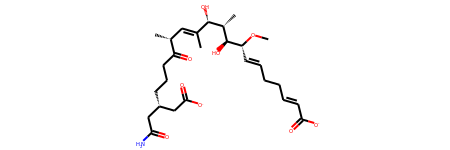

In [84]:
# This molecule doesn't have a Murcko Scaffold (its
df_murcko[df_murcko['scff_generic'] == '']
df_murcko.loc[678, 'mol_rdk']

In [62]:
# How many scaffolds have less than five molecules?
sum(scff_counts > 5)

167

### Visualize Generic Scaffolds against Normal Scaffolds

In [63]:
# Function to get mol from scaffold smiles
toSmiles = Chem.MolFromSmiles

#### First Example

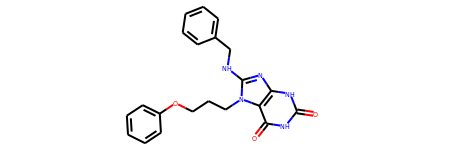

In [64]:
name = 1759
toSmiles(df_murcko.loc[name, 'scff'])

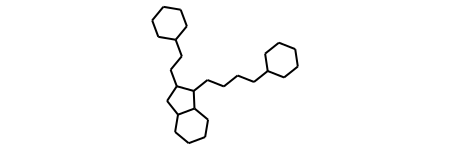

In [65]:
name = 1759
toSmiles(df_murcko.loc[name, 'scff_generic'])

#### Second Example

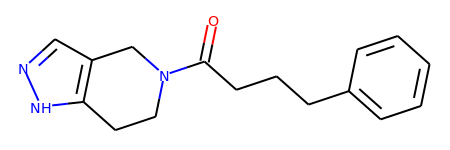

In [66]:
name = 234 
toSmiles(df_murcko.loc[name, 'scff'])

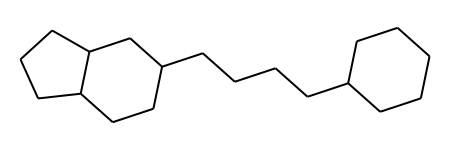

In [67]:
name = 234 

toSmiles(df_murcko.loc[name, 'scff_generic'])